<a href="https://colab.research.google.com/github/flaghunter21/DSCI-619-Deep-Learning/blob/main/DSCI_619_Project_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSCI 619 Project 6
## Language Translation with sequence to sequence model using RNN

We will develop a sequence to sequence model using RNN to translate English to German. 

Data Source: [Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)

Information on Sequence to Sequence learning in Keras can be found here: 

[Ten Minute Introduction to sequence to sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

[Character-level Recurrent Sequence to Sequence Model](https://keras.io/examples/nlp/lstm_seq2seq/)

## Import Data

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Fix seeds
seed = 101
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Our data is taken from the [Tatoeba Project](https://tatoeba.org/en) which provides tab-delimited bilingual sentence pairs. The data has the following format:

English + TAB + Other Language + TAB + Attribution

An example of the data is as follows:

Go.	Geh.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)

Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)

## Set Model Hyperparameters

In [2]:
batch_size = 64 # Batch size training
epochs = 100 # Epochs training
latent_dim = 256 # Latent dimensionality of encoding space
num_samples = 10000 # Number of samples
data_path = 'deu-eng.txt'

## Prepare the Data

Each row contains input text and target text. We need to seperate them as such. We also find each unique character in the input text and target text. This is what our model will use to make predictions. 

In [4]:
# Obtain input and target
input_texts = []
target_texts = []
# Unique characters
input_characters = set()
target_characters = set()
# Load data
with open(data_path, "r", encoding="utf-8") as f:
  lines = f.read().split("\n")
# Process data line by line
for line in lines[: min(num_samples, len(lines)-1)]:
  # We discard the Attribution
  input_text, target_text, _ = line.split("\t")
  # Tab is the start sequence character and newline is the end sequence character
  target_text = "\t" + target_text + "\n"
  # Append text to our empty lists
  input_texts.append(input_text)
  target_texts.append(target_text)
  # Get unique characters from input text
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  # Get unique characters from target text
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

We have now seperated the input text and target text. We also have the unique characters used in input and target text. Now, we sort the input and target characters and get the length of the encoder and decoder tokens. We alsofind the maximum size of the input and target texts.

In [26]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 85
Max sequence length for inputs: 15
Max sequence length for outputs: 45


Since machine learning models can only handle numeric data, we need to convert the characters to numerical values. We will create a dictionary mapping each character to an index. The key will be the character and the value its index.

In [27]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [29]:
input_token_index

{' ': 0,
 '!': 1,
 '"': 2,
 '$': 3,
 '%': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 '9': 18,
 ':': 19,
 '?': 20,
 'A': 21,
 'B': 22,
 'C': 23,
 'D': 24,
 'E': 25,
 'F': 26,
 'G': 27,
 'H': 28,
 'I': 29,
 'J': 30,
 'K': 31,
 'L': 32,
 'M': 33,
 'N': 34,
 'O': 35,
 'P': 36,
 'Q': 37,
 'R': 38,
 'S': 39,
 'T': 40,
 'U': 41,
 'V': 42,
 'W': 43,
 'Y': 44,
 'a': 45,
 'b': 46,
 'c': 47,
 'd': 48,
 'e': 49,
 'f': 50,
 'g': 51,
 'h': 52,
 'i': 53,
 'j': 54,
 'k': 55,
 'l': 56,
 'm': 57,
 'n': 58,
 'o': 59,
 'p': 60,
 'q': 61,
 'r': 62,
 's': 63,
 't': 64,
 'u': 65,
 'v': 66,
 'w': 67,
 'x': 68,
 'y': 69,
 'z': 70}

In [30]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '$': 4,
 '%': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '4': 14,
 '5': 15,
 '6': 16,
 '7': 17,
 '8': 18,
 '9': 19,
 ':': 20,
 '?': 21,
 'A': 22,
 'B': 23,
 'C': 24,
 'D': 25,
 'E': 26,
 'F': 27,
 'G': 28,
 'H': 29,
 'I': 30,
 'J': 31,
 'K': 32,
 'L': 33,
 'M': 34,
 'N': 35,
 'O': 36,
 'P': 37,
 'Q': 38,
 'R': 39,
 'S': 40,
 'T': 41,
 'U': 42,
 'V': 43,
 'W': 44,
 'Y': 45,
 'Z': 46,
 'a': 47,
 'b': 48,
 'c': 49,
 'd': 50,
 'e': 51,
 'f': 52,
 'g': 53,
 'h': 54,
 'i': 55,
 'j': 56,
 'k': 57,
 'l': 58,
 'm': 59,
 'n': 60,
 'o': 61,
 'p': 62,
 'q': 63,
 'r': 64,
 's': 65,
 't': 66,
 'u': 67,
 'v': 68,
 'w': 69,
 'x': 70,
 'y': 71,
 'z': 72,
 '\xa0': 73,
 'Ä': 74,
 'Ö': 75,
 'Ü': 76,
 'ß': 77,
 'ä': 78,
 'ö': 79,
 'ü': 80,
 '’': 81,
 '“': 82,
 '„': 83,
 '\u202f': 84}

We now turn the sentences into three different NumPy arrays. The arrays will have three dimensions:
* The first dimension denotes the number of samples.
* The second dimension shows max length of input or target text.
* The third dimension denotes the number of unique characters.

The elements of each matrix will be made up of 0 and 1. 
* 0 if character does not show up in the text.
* 1 if character does show up in the text.

In [52]:
# 3D Matrix
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype="float32")
# Convert text to numerical values
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0
  # Pad remaining space mapped to 1
  encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
  for t, char in enumerate(target_text):
    decoder_input_data[i, t, target_token_index[char]] = 1.0
    if t > 0:
      decoder_target_data[i, t-1, target_token_index[char]] = 1.0
  decoder_input_data[i, t+1 :, target_token_index[" "]] = 1.0
  decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## Build the Model

The RNN model has two layers:

* A LSTM encoder layer
* A LSTM decoder layer

The encoder layer processes the input text and returns its own internal state. The hidden states are the "context" of the decoder and the output of the encoder is discarded.

The decoder layer is trained to predict the next characters of the target sequence given previous characters. This model uses "teacher forcing" which turns the target sequence into the same sequence but offset by one timestep in the future. 

In [56]:
## Encoder Layers
# Input sequence
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
# Define LSTM
encoder = keras.layers.LSTM(latent_dim, return_state=True)
# Apply LSTM
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Discard outputs and keep states
encoder_states = [state_h, state_c]

## Decoder Layers
# Decoder Input
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
# LSTM
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
# Set up decoder using encoder_states as initial state
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# Forecast decoder outputs
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Model Configuration and Training

Since this is a multiclass classification problem, we configure the model using "rmsprop" optimizer and the "categorical_crossentropy" loss function.

In [57]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [58]:
from tensorflow.keras.callbacks import EarlyStopping
# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001, mode='max')
history = model.fit([encoder_input_data, decoder_input_data], 
                     decoder_target_data, 
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2,
                     callbacks=[early_stopping],)
# Save model
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 44s 329ms/step - loss: 1.4824 - accuracy: 0.6457 - val_loss: 1.3437 - val_accuracy: 0.6152
Epoch 2/100
125/125 [==============================] - 39s 309ms/step - loss: 1.0574 - accuracy: 0.7183 - val_loss: 1.0400 - val_accuracy: 0.7119
Epoch 3/100
125/125 [==============================] - 39s 316ms/step - loss: 0.8431 - accuracy: 0.7678 - val_loss: 0.8835 - val_accuracy: 0.7549
Epoch 4/100
125/125 [==============================] - 41s 331ms/step - loss: 0.7315 - accuracy: 0.7919 - val_loss: 0.8027 - val_accuracy: 0.7715
Epoch 5/100
125/125 [==============================] - 39s 314ms/step - loss: 0.6680 - accuracy: 0.8080 - val_loss: 0.7556 - val_accuracy: 0.7867
Epoch 6/100
125/125 [==============================] - 39s 309ms/step - loss: 0.6219 - accuracy: 0.8201 - val_loss: 0.7185 - val_accuracy: 0.7957
Epoch 7/100
125/125 [==============================] - 38s 308ms/step - loss: 0.5846 - accuracy: 0.8306 - val_loss: 0.6894 -

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


## Model Diagnostics

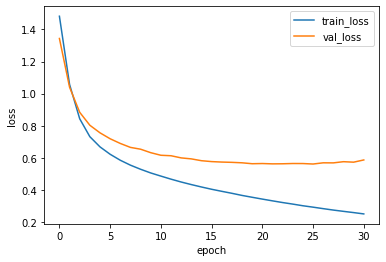

In [59]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

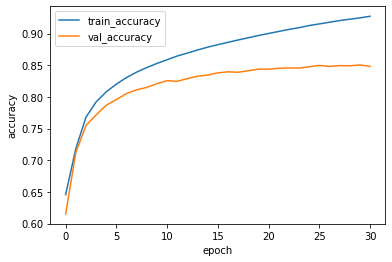

In [60]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## Run Inference

To decode unkown inputs, we provide the inputs and correspondsing states. These states contain the context of the text.

We look at the model architecture to identify the layers to use in the inference model.

In [61]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, 71)]   0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None, 85)]   0           []                               
                                                                                                  
 lstm_10 (LSTM)                 [(None, 256),        335872      ['input_11[0][0]']               
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

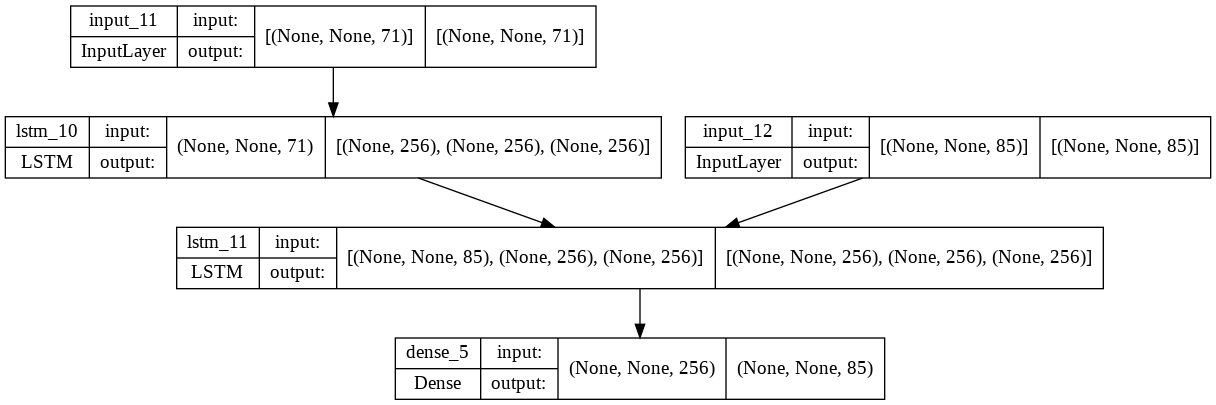

In [62]:
tf.keras.utils.plot_model(model, show_shapes=True)